In [3]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
sys.path.append("../")
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [4]:
from utils.common import (
    sigmoid, reverse_sigmoid,
    pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric, 
    plot_score_distribution, train_logistic_regression
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols, plot_heatmap
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)

In [5]:
%load_ext autoreload
%autoreload

### Read Data

In [7]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")
target = labels["target"]
labels.head(2)

Shape of data: (458913, 2)


,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [9]:
num_statements_df = read_file(f"../{RAW_DATA_PATH}/train_num_statements.csv")
num_statements_df.head(2)

Shape of data: (458913, 2)


,customer_ID,num_statements
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13


In [12]:
train_score1 = read_file(f"../{EXP_PATH}/1.lgbm_dart_923/train_scores_df.csv")
train_score2 = read_file(f"../{EXP_PATH}/2.lgbm_dart_1020/train_scores_df.csv")
# train_score3 = read_file(f"../{EXP_PATH}/3.lgbm_dart_5197/train_scores_df.csv")
train_score4 = read_file(f"../{EXP_PATH}/4.lgbm_dart_6666/train_scores_df.csv")
# train_score5 = read_file(f"../{EXP_PATH}/5.lgbm_dart_923_half_fix/train_scores_df.csv")
train_score9 = read_file(f"../{EXP_PATH}/9.lgbm_dart_1234/train_scores_df.csv")

Shape of data: (458913, 8)
Shape of data: (458913, 8)
Shape of data: (458913, 8)
Shape of data: (458913, 8)


In [13]:
t1 = train_score1["cv_score"].values
t2 = train_score2["cv_score"].values
# t3 = train_score3["cv_score"].values
t4 = train_score4["cv_score"].values
# t5 = train_score5["cv_score"].values
t9 = train_score9["oof_score"].values

### Train Logistic Regression

In [14]:
X_train = pd.DataFrame(dict(
    # statement_count=num_statements_df["num_statements"], 
    oof1=t1,
    oof2=t2,
    # oof3=t3,
    oof4=t4,
    # oof5=t5,
    oof9=t9,
    # target=labels["target"]
))#.values

In [15]:
X_train.describe()

,oof1,oof2,oof4,oof9
count,458913.000000,458913.000000,458913.000000,458913.000000
mean,-2.670165,-2.601158,-2.707905,-2.644917
std,3.742455,3.642975,3.757464,3.693017
min,-9.951277,-9.597510,-10.496748,-9.594308
25%,-5.852811,-5.721689,-5.898782,-5.794857
50%,-3.441199,-3.347013,-3.490815,-3.405300
75%,0.343257,0.359714,0.313746,0.348891
max,9.244411,8.632654,9.233799,8.826942


In [17]:
X_train["ratio19"] = X_train["oof1"] / X_train["oof9"]

0.7999492909171364 0.7999755235995082


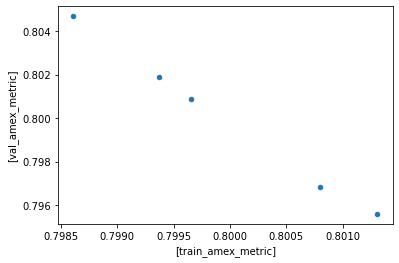

In [18]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train, labels["target"])
print(metrics_df["train_amex_metric"].mean(), metrics_df["val_amex_metric"].mean())
metrics_df.plot.scatter(x=["train_amex_metric"], y=["val_amex_metric"])
plt.show()

In [20]:
preds = []
for clf in clf_list:
    preds.append(clf.predict_proba(X_train)[:, 1])
final_score = np.mean(preds, axis=0)

In [21]:
labels["stacked_oof_score"] = final_score

In [23]:
labels.to_csv("./residual.csv", index=False)

In [23]:
X_train["sign"] = X_train.iloc[:, :6].apply(lambda x: 1 if sum([i > 0 for i in x]) > 1 else -1, axis=1)

In [24]:
X_train["sign"].value_counts(normalize=True)

-1    0.715992
 1    0.284008
Name: sign, dtype: float64

In [25]:
X_train["final"] = X_train["sign"] * X_train.iloc[:, :6].product(axis=1)

In [110]:
# X_train["final"]

In [28]:
amex_metric(labels["target"].values, X_train["final"].values)

(0.799512065101186, 0.9262365717144734, 0.6727875584878985)

In [274]:
X_train_ = X_train.drop(columns=["oof3", "oof5"])


In [275]:
# X_train_["num"] = num_statements_df["num_statements"].values
# X_train_["std"] = X_train_.std(axis=1)
# X_train_["mean"] = X_train_.mean(axis=1)
# X_train_["median"] = X_train_.median(axis=1)

0.7999492909171364 0.7999755235995082


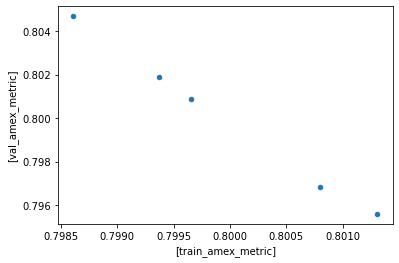

0.799961694224554 0.7999180569371129


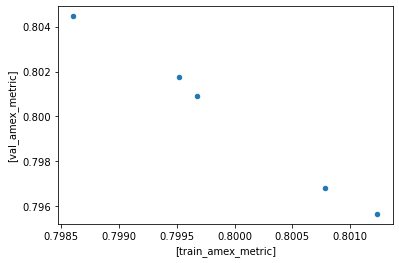

In [254]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train_, labels["target"])
print(metrics_df["train_amex_metric"].mean(), metrics_df["val_amex_metric"].mean())
metrics_df.plot.scatter(x=["train_amex_metric"], y=["val_amex_metric"])
plt.show()

In [111]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train, labels["target"])

In [121]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train, labels["target"], min_max_scaled=True)

In [119]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train, labels["target"], std_scaled=True)

In [123]:
X_train["num"] = num_statements_df["num_statements"].values
X_train["max"] = X_train.max(axis=1)
X_train["min"] = X_train.min(axis=1)
X_train["median"] = X_train.median(axis=1)
X_train["mean"] = X_train.mean(axis=1)
X_train["skew"] = X_train.skew(axis=1)
X_train["std"] = X_train.std(axis=1)

In [124]:
X_train_drop_oof = X_train.drop(columns=get_cols(X_train, ["oof"]), errors="ignore")

In [125]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train_drop_oof, labels["target"])

In [127]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train_drop_oof, labels["target"], min_max_scaled=True)

In [129]:
metrics_df, clf_list, min_max_scaler, std_scaler = train_logistic_regression(X_train_drop_oof, labels["target"], std_scaled=True)

In [422]:
# X_train_["median_larger"] = (X_train_["median"] > X_train_["mean"]).astype(int)

In [423]:
X_train_["positive_skew"] = (X_train_["skew"] > 0).astype(int)

In [424]:
X_train_["high_std"] = (X_train_["std"] > 0.2).astype(int)

In [425]:
X_train_["is_full_statements"] = np.where(num_statements_df["num_statements"] == 13, 1, 0)

In [426]:
# X_train_.groupby("high_std")["target"].mean()

In [427]:
# X_train_.groupby("median_larger")["target"].mean()

In [429]:
y_train = target

In [431]:
X_train_ = X_train_.drop(columns=["median", "skew", "std"], errors='ignore')

In [433]:
X_train_.drop(columns=get_cols(X_train_, "oof"), inplace=True)

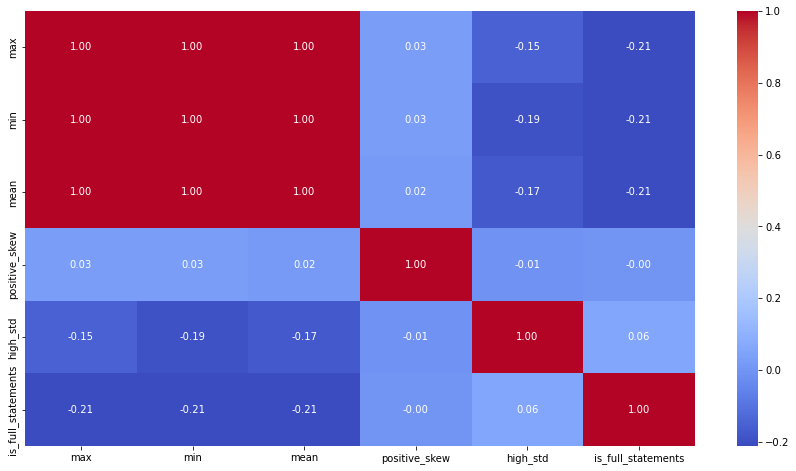

In [435]:
plot_heatmap(X_train_.corr(), annot=True, fmt=".2f")

In [436]:
final_oof_score, min_max_scaler, clf_list = train_logistic_regression(X_train_, y_train_)

1 0.8000615133263818 0.7974836564826935
2 0.7999891714062497 0.7979710690443198
3 0.7992819320851674 0.8006549485063224
4 0.7992045783600361 0.8015070836906751
5 0.7993032805950401 0.8009747880596201


In [437]:
final_oof_score

0.7997183091567261

In [304]:
final_oof_score, min_max_scaler = train_logistic_regression(X_train_, y_train_)

1 0.800443744438765 0.7977839747573845
2 0.8004454425449861 0.7980198655419419
3 0.7996422732225261 0.8010617674997593
4 0.799687983094375 0.8015466264779496
5 0.7995645376966464 0.8015415139936592


In [364]:
# final_oof_score

In [186]:
y_pred = pd.Series(X_train_.iloc[:, 1:].mean(axis=1), name="prediction")
y_true = labels[["target"]]

In [190]:
result = get_final_metric_df(X_train_, y_true, y_pred)
# result

In [131]:
default_df = result.loc[result["target"] == 1]
non_default_df = result.loc[result["target"] == 0]

In [132]:
result.loc[default_df.index, "ground_truth"] = 10 - default_df["prediction"]
result.loc[non_default_df.index, "ground_truth"] = -10 - non_default_df["prediction"]

In [191]:
# result.sort_index()["ground_truth"].to_csv(f"{RAW_DATA_PATH}/oof_residuals.csv", index=False)

In [75]:
y_train_ = train_score1["target"]

In [77]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train_, y_train_, test_size=0.2, random_state=1020, stratify=y_train_)

In [78]:
# RandomForestClassifier(
#     random_state=1020,
#     n_estimators=16,
#     max_depth=3
# )

In [259]:
clf_list

[LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0),
 LogisticRegression(class_weight=[0.8, 0.2], random_state=0)]

### Inference Logistic Regression

In [524]:
test_score1 = read_file(f"{EXP_PATH}/1.lgbm_dart_923/scores_df.csv")
test_score2 = read_file(f"{EXP_PATH}/2.lgbm_dart_1020/scores_df.csv")
test_score3 = read_file(f"{EXP_PATH}/3.lgbm_dart_5197/scores_df.csv")
test_score4 = read_file(f"{EXP_PATH}/4.lgbm_dart_6666/scores_df.csv")
test_score5 = read_file(f"{EXP_PATH}/5.lgbm_dart_923_half_fix/scores_df.csv")
test_score9 = read_file(f"{EXP_PATH}/9.lgbm_dart_1234/scores_df.csv")

Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)


In [526]:
X_test = pd.DataFrame(dict(
    oof1=test_score1.mean(axis=1),
    oof2=test_score2.mean(axis=1),
    oof3=test_score3.mean(axis=1),
    oof4=test_score4.mean(axis=1),
    oof5=test_score5.mean(axis=1),
    oof9=test_score9.mean(axis=1),
))

In [527]:
X_test.describe()

,oof1,oof2,oof3,oof4,oof5,oof9
count,924621.000000,924621.000000,924621.000000,924621.000000,924621.000000,924621.000000
mean,-2.820171,-2.668789,-2.557505,-2.785014,-2.403696,-2.334553
std,3.666374,3.536575,3.390589,3.650078,3.388094,3.380484
min,-10.387791,-9.701672,-8.620816,-10.433451,-9.221664,-9.096469
25%,-5.918643,-5.673748,-5.479695,-5.861947,-5.283300,-5.205590
50%,-3.590192,-3.413813,-3.285391,-3.564410,-3.105985,-3.026107
75%,0.055471,0.122169,0.148526,0.071756,0.255458,0.291655
max,8.997256,8.311370,7.426380,9.085598,8.276772,8.601988


In [532]:
X_test["sign"] = X_test.iloc[:, :6].apply(lambda x: 1 if sum([i > 0 for i in x]) > 0 else -1, axis=1)

In [533]:
X_test["sign"].value_counts(normalize=True)

-1    0.722114
 1    0.277886
Name: sign, dtype: float64

In [534]:
X_test["final"] = X_test["sign"] * X_test.iloc[:, :6].product(axis=1)

In [535]:
X_test["final"]

0          -2795.983483
1        -118805.283677
2          -1337.491168
3             -1.177207
4             74.055588
              ...      
924616     -3746.129943
924617        80.116153
924618         0.000007
924619        -0.052188
924620      -652.852610
Name: final, Length: 924621, dtype: float64

In [536]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = X_test["final"].values
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_21TH_blend_6_darts_product_sign.csv", index=False)

In [271]:
X_test_ = mscaler.fit_transform(X_test_)

In [272]:
preds = []
for clf in clf_list:
    preds.append(clf.predict_proba(X_test_)[:, 1])
final_score = np.mean(preds, axis=0)

In [295]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = test_score9.mean(axis=1)
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_20TH_vanilla_experiment9_seed_1234_average.csv", index=False)

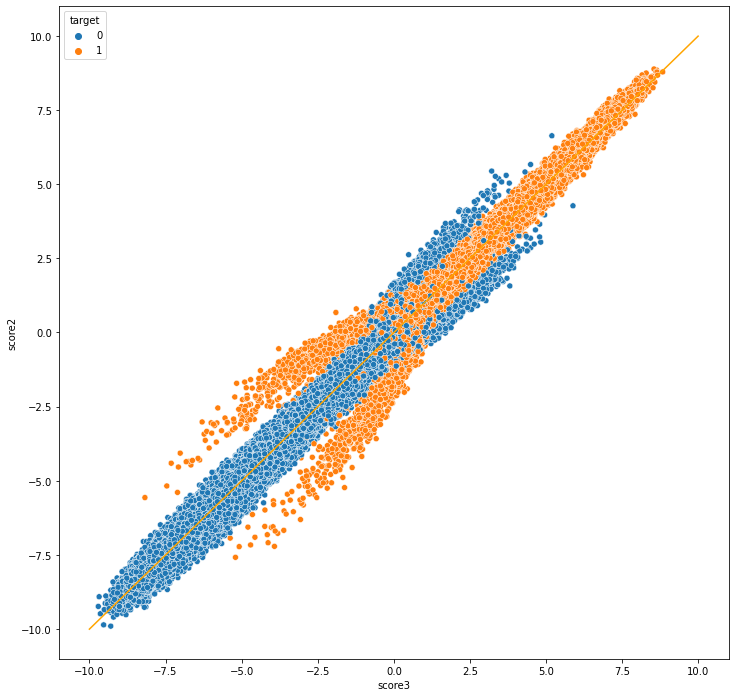

In [288]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=train_score9["score3"], y=train_score9["score2"], hue=train_score9["target"])
plt.plot(np.arange(-10, 10, 0.01), np.arange(-10, 10, 0.01), color="orange", linestyle="-")
plt.show()

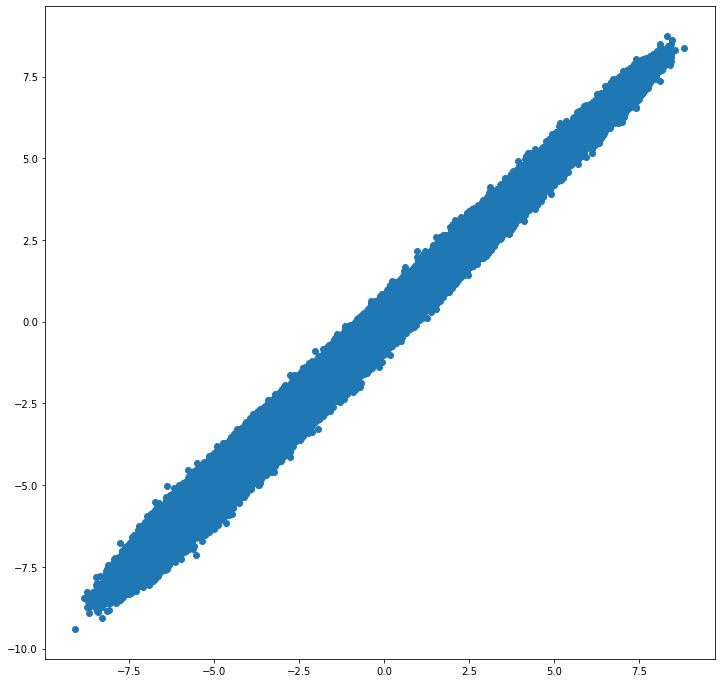

In [291]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(test_score9["score3"], test_score9["score4"])
plt.show()

In [320]:
X_train_

array([[-8.02558655, -7.53088904, -7.79839396, -7.60327302],
       [-6.99587721, -7.35056828, -6.93377296, -6.69328752],
       [-7.18439325, -7.41133143, -7.42501141, -6.87409778],
       ...,
       [-6.70857283, -6.57018898, -6.23910077, -6.91964404],
       [-1.92453839, -1.77250317, -2.02940995, -1.83362764],
       [-6.05023009, -5.61319556, -5.86492798, -6.06270989]])

In [309]:
train_logistic_regression(train_score9.iloc[:, 1:6], train_score9["target"])

1 0.9177395453552648 0.9147245439781231
2 0.9176590112157511 0.9154084195918446
3 0.9168789304266861 0.9178542129526484
4 0.9170827886312676 0.917669110876592
5 0.9162863591277919 0.919863841202062


(0.917104025720254, MinMaxScaler())

In [276]:
test_score9[["score1",

,score1,score2,score3,score4,score5
0,-3.821564,-3.461997,-3.348870,-3.586271,-3.312073
1,-6.860182,-6.537879,-6.262872,-6.682696,-6.887376
2,-3.013238,-3.461611,-3.004113,-3.050773,-3.447362
3,-0.770930,-0.884658,-0.407027,-0.646863,-0.650042
4,2.198048,2.433070,2.088249,2.327092,2.377117
...,...,...,...,...,...
924616,-3.365608,-3.708212,-3.481497,-3.755893,-3.605609
924617,2.205423,1.850653,2.136378,2.145076,1.963180
924618,-0.259439,0.104114,-0.125630,-0.281783,0.016716
924619,-0.713172,-0.414007,-0.342954,-0.312344,-0.337855


In [297]:
test_score9

,score1,score2,score3,score4,score5
0,-3.821564,-3.461997,-3.348870,-3.586271,-3.312073
1,-6.860182,-6.537879,-6.262872,-6.682696,-6.887376
2,-3.013238,-3.461611,-3.004113,-3.050773,-3.447362
3,-0.770930,-0.884658,-0.407027,-0.646863,-0.650042
4,2.198048,2.433070,2.088249,2.327092,2.377117
...,...,...,...,...,...
924616,-3.365608,-3.708212,-3.481497,-3.755893,-3.605609
924617,2.205423,1.850653,2.136378,2.145076,1.963180
924618,-0.259439,0.104114,-0.125630,-0.281783,0.016716
924619,-0.713172,-0.414007,-0.342954,-0.312344,-0.337855


### BLEND TEST

Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)
Shape of data: (924621, 5)


In [20]:
s = read_file(f"{SUBMISSION_DATA_PATH}/submission3_lgbm_dart_full_fix_1020.csv")["prediction"]

Shape of data: (924621, 2)


In [26]:
s2 = test_score2.mean(axis=1)

In [64]:
m = MinMaxScaler()

In [33]:
test_score2_ = m.fit_transform(test_score2)

In [35]:
np.mean(test_score2_, axis=1)

array([0.32552628, 0.14096738, 0.35586654, ..., 0.52899043, 0.49217374,
       0.36775012])

In [36]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = np.mean(test_score2_, axis=1)
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_9TH_seed_1020_average_fold_after_minmaxscaler.csv", index=False)

In [67]:
sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/empty.csv")
sub["prediction"] = (
    (0.4 * m.fit_transform(test_score1).mean(axis=1)) + 
    (0.1 * m.fit_transform(test_score2).mean(axis=1)) + 
    (0.2 * m.fit_transform(test_score3).mean(axis=1)) + 
    (0.1 * m.fit_transform(test_score4).mean(axis=1)) +
    (0.1 * m.fit_transform(test_score5).mean(axis=1))
) / 0.9
sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission_10TH_blend_5_own_seeds_after_min_max_scaled.csv", index=False)

In [68]:
sub["prediction"].describe()

count    924621.000000
mean          0.385767
std           0.194353
min           0.000000
25%           0.220337
50%           0.344674
75%           0.538963
max           0.994977
Name: prediction, dtype: float64

In [7]:
## 1ST - 0.799 (medium)
amex_metric(train_score1["target"], t1)

(0.7986772206700369, 0.9259891065704908, 0.6713653347695829)

In [8]:
## 3RD - 0.800 (low)
amex_metric(train_score1["target"], t2)

(0.7987062094874274, 0.9260807463051137, 0.6713316726697411)

In [9]:
## 5TH - 0.799 (low)
amex_metric(train_score1["target"], t3)

(0.797788577455728, 0.925642459385149, 0.6699346955263069)

In [10]:
### 6TH - 0.800 (very low)
amex_metric(train_score1["target"], t4)

(0.7987959566465116, 0.9262181629984798, 0.6713737502945434)

In [11]:
### 7TH - 0.798 (high)
amex_metric(train_score1["target"], t5)

(0.7971742806455548, 0.9257687652834348, 0.6685797960076749)